In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 21:26:45 2018
@author: Fabio
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pandas as pd
import os
import csv
from networkx.algorithms import bipartite

t0=time.time()

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
Amigos=ldata("Brightkite_edges.txt")
Ubicacion=ldata("Brightkite_totalCheckins.txt")

# Algo que debí definir antes y nunca hice

Maxusu= int(Amigos[len(Amigos)-1][0])

G = nx.Graph()

G.add_edges_from(Amigos)

#--------------------------------------------------------------------------

# os.walk lo que hace es recorrer la carpeta y todas las subcarpetas adentro.
# Root es el path de la carpeta en la que está mirando
# dirs son los nombres de las carpetas dentro de root
# Files son los nombres de todos los archivos dentro de root

# La cosa es que te queda listas dentro de listas. Para cada carpeta que tenga
# Que revisar, va a armar una lista diferente. Así que si le pedís que analice una
# Carpeta con 4 carpetas adentro, te van a quedar en total cinco listas.

# A cada una de estas listas, en la primer coordenada pone el path para entrar a esa carpeta.
# En la segunda coordenada, pone una lista con los nombres de todas las carpetas contenidas
# En la tercer coordenada, pone otra lista con los nombres de todos los archivos contenidos.

CarpCheck=[[root,files] for root,dirs,files in os.walk('Checkins nodo/')]

# Como a CarpCheck yo lo hice usando solo root y files, es una lista que se saltea
# Los nombres de las carpetas contenidas


# Nombre de los archivos de Checkins

Labarc= CarpCheck[0][1]

#--------------------------------------------------------------------------------------------

# NCC es Nodos con Check in
NCC=[]

for x in Labarc:
    if x!="Nodosvacios.csv":
        linea=x.split(",") # Separo en la coma, porque viene justo despues del nodo
        name=linea[0].split("n") # Separo en la n porque viene justo antes del nodo
        # Ahora name es SIEMPRE una lista de 2 elementos. Yo quiero el segundo, que es el nodo
        node=name[1]
        NCC.append(node)

        
# Lo ordeno porque el walk los recorrio por orden alfabético
# Son strings, los paso a enteros

for i in range(len(NCC)):
    NCC[i]=int(NCC[i])    
    
# Ahora que son enteros los puedo ordenar

NCC.sort()

# Calculemos ahora sí los que están vacíos

NotCC=[]

m= 0

for j in range(Maxusu+1):
    if j!= NCC[j-m]:
        NotCC.append(j)
        m +=1
#---------------------------------------------------------------------------

DictID = dict()
DictIDT = dict()
DictALID = dict()
DictFID = dict()

for nombre in Labarc:
    if nombre != "Nodosvacios.csv":
        ListaID = []
        ListaALID = []
        ListaIDT = []
        ListaFID = []
        with open("Checkins nodo/{}".format(nombre), newline='') as csvfile:
            # Con el with open abrí mi archivo como csv
            # Con el format voy a recorrer todos los archivos en mi carptea Checkins nodo
            Dat= csv.reader(csvfile, delimiter=',', quotechar='|')
            Data= list(Dat)
            nodo= Data[1][1] # La fila 1 la elegí porque no todos los nodos tienen más de un checkin
            for x in Data[1:]:
                # Me deshago de la isla nula
                if x[5]!="00000000000000000000000000000000":
                    # Le pongo de 1 en adelante porque la primer fila son nombres de columnas
                    if x[5] not in ListaID:
                        ListaID.append(x[5])
                        ListaALID.append([[x[3],x[4]],x[5]])
                    ListaIDT.append(x[5])
                    # Acá armo un Diccionario de fechas
                    dada = x[2].split("T") # Separo en la T, lo de la izquierda es AAAA-MM-DD
                    fechas = dada[0].split("-") # fechas[0]=AAAA, fechas[1]=MM, fechas[2]==DD
                    ListaFID.append([fechas[0],fechas[1],fechas[2],x[5]])
            DictIDT[nodo]=ListaIDT
            DictID[nodo]=ListaID
            DictALID[nodo]=ListaALID
            DictFID[nodo]=ListaFID
            
#-------------------------------------------------------------------------

Nodos= list(G.nodes())

Nodos.sort()

Bip=nx.Graph()
Bip.add_nodes_from(Nodos, bipartite = 0, color="orange")

# Con eso agregué todos los usuarios a la red, y les asigne bipartite = 0
for nodo in DictID.keys():
    Bip.add_nodes_from(DictID[nodo], bipartite = 1, color="blue")

# Con eso asigné todos los ID's al grafo, con bipartite = 1.
# De paso, que se repitan no es ningún problema, ya lo comprobé

# Ahora viene lo gede
for nodo in DictID.keys():
    Tuplas = []
    for lugar in DictID[nodo]:
        weight = DictIDT[nodo].count(lugar)
        Tuplas.append((nodo,lugar,weight))
    Bip.add_weighted_edges_from(Tuplas)
    
Mam = set(n for n,d in Bip.nodes(data=True) if d['bipartite']==0)
Lugares = set(Bip) - Mam

Lugares=list(Lugares)

Mad = bipartite.biadjacency_matrix(Bip,row_order = Nodos, column_order = Lugares)

#-------------------------------------------------------------------------------------------

# Cosas por hacer: Comparar similitudes entre matrices. Para esto, hay tres métodos a mirar:
# 1) Comparar los enlaces formados entre la red de amigos y la red proyectada de usuarios
# 2) Clusterizar la red y luego comparar los grupos para una red 
# y para la otra mediante información mutua
# 3) Lo mismo que para el 2 pero con Precisión

#---------------------------------------------------------------------

# Armemos el grafo proyectado
# Correr esto puede llegar a ser pesado, asegurate de hacerlo primero. O de guardar los archivos
# EnlaG y EnlaP

Proyec = bipartite.projected_graph(Bip,Nodos)

# Ahora que tengo esto, tengo que empezar a plantearme como comparar los enlaces

EnlaG = G.edges()

EnlaP = Proyec.edges()

# Hacer las listas no tardó tanto, 4 segundos

LEnlaG = [[int(x[0]),int(x[1])] for x in EnlaG]
LEnlaP = [[int(x[0]),int(x[1])] for x in EnlaP]

for i in range(len(LEnlaP)):
    if i < len(LEnlaG):
        if LEnlaG[i][0]>=LEnlaG[i][1]:
            LEnlaG[i]=[LEnlaG[i][1],LEnlaG[i][0]]
    if LEnlaP[i][0]>=LEnlaP[i][1]:
        LEnlaP[i]=[LEnlaP[i][1],LEnlaP[i][0]]
        
LEnlaG.sort(key=lambda x: x[0])
LEnlaP.sort(key=lambda x: x[0])

# GradoP = Proyec.degree()

# gradmax=0

# for x in GradoP:
#     gradmax=max(gradmax,x[1])
    
# Para no hacer la cuenta de nuevo, el grado máximo en la red proyectada es 11645

Rangos = []
# inicio es como el ret en su momento. A cada iteracion me marca
# Cuantas filas de cada nodo encontro, y luego empieza justo en la primera del siguiente nodo
inicio = 0
n=1
for nodo in range(Maxusu+1):
    Rangos.append([inicio,0])
    for enlace in LEnlaP[inicio:inicio+15000]:
        if enlace[0]!=nodo:
            break
        inicio += 1
    Rangos[nodo][1] = inicio
    if nodo==n*1000:
        print("Estoy trabajando amo, ya hice hasta el nodo",nodo)
        n += 1

# Ya tengo los rangos calculados, ahora si puedo hacer el estudio de los enlaces

# fracen=0
# Den=len(G.edges())

# for enlace1 in LEnlaG:
#     for enlace2 in LEnlaP[Rangos[enlace1[0]][0]:Rangos[enlace1[0]][1]]:
#         if enlace1==enlace2:
#             fracen += 1/Den
#             break
            
print("La fracción de enlaces que se repiten en ambos grafos es:",fracen)

# El fracen me dió 0.27579. Así te ahorrás la cuenta

# ¿Cuál es el porcentaje de los enlaces que no tienen checkin?

fracnot=0

for x in LEnlaG:
    if x[0] in NotCC:
        fracnot += 1/Den
    else:
        if x[1] in NotCC:
            fracnot += 1/Den

print("La fracción de enlaces en la red original cuyos usuarios no tienen checkins es:",fracnot)
# Me dio 0,0789, así te ahorrás la cuenta    

Tiempo()

# Corrrer solo una vez

Esto tardó 146.92940402030945 segundos


In [36]:
t0=time.time()

with open("Checkins nodo/{}".format(Labarc[0]), newline='') as csvfile:
    # Con el with open abrí mi archivo como csv
    # Con el format voy a recorrer todos los archivos en mi carptea Checkins nodo
    Dat= csv.reader(csvfile, delimiter=',', quotechar='|')
    Data= list(Dat)
    # Acá armo un Diccionario de fechas
    for x in Data[2:6]:
        dada = x[2].split("T") # Separo en la T, lo de la izquierda es AAAA-MM-DD
        fechas = dada[0].split("-") # fechas[0]=AAAA, fechas[1]=MM, fechas[2]==DD
        print(fechas)


    

Tiempo()

['2010', '10', '16']
['2010', '10', '16']
['2010', '10', '14']
['2010', '10', '14']
Esto tardó 0.05100297927856445 segundos


0.2757966722408626
Esto tardó 0.0 segundos


In [28]:
#Pruebas

A=[0,1,2,3,4,5,6,7]

print(A[2:4])


# Celda con cosas de ayudas
       
# Para acceder a un elemento, o filas, basta con ponerlo entre corchetes
# print(Mad[2,15])

# Ya que use las listas Nodos y Lugares para organizar las filas y columnas,
# Mad debería tener una cantidad de filas = len(Nodos) y cantidad de columnas = len(Lugares)

# print(len(Nodos))
# print(len(Lugares))
# print(Mad[60000,12])

# Fijate al final del error, podés ver el largo de la matriz. Que lindo

#------------------------------------------------------------------------
# ¿Cuantos tipos de alto grado no tienen Checkins?

# n=0
# for x in NotCC:
#     if DictGrado[str(x)]>=100:
#         n +=1
# print("Hay {} nodos de grado mayor a 100 sin Check-ins".format(n))

# m=0
# for x in DictGrado.values():
#     if x>=100:
#         m +=1
# print("Hay {} nodos de grado mayor a 100".format(m))

# print("La fracción de nodos sin Check-ins de alto grado es:",n/m)

#----------------------------------------------------------------------------

# Ejemplo de como armar un grafo bipartito. Usalo para jugar cuando no entiendas que
# cosa no funciona

# A = [1,2,3,4,5,6]
# B = ["a","b","c","d"]

# Pip = nx.Graph()
# Pip.add_nodes_from(A, bipartite = 0)
# Pip.add_nodes_from(B, bipartite = 1)
# Pip.add_edges_from([(1,"a"),(1,"b"),(1,"c"),(2,"a"),(2,"c")])
# Pip.add_edges_from([(2,"d"),(3,"a"),(3,"b"),(4,"c"),(4,"d"),(5,"b"),(6,"d")], weight = 4)

# bottom_nodes, top_nodes = bipartite.sets(Pip)

# print("Los top son:")
# print(top_nodes)
# print("Los bottom son:")
# print(bottom_nodes)

# M = bipartite.biadjacency_matrix(Pip,row_order = A,column_order = B)


# R = bipartite.projected_graph(Pip, top_nodes)

# nx.draw(R,with_labels=True)
# plt.show()

#---------------------------------------------------------------------------



[2, 3]


Esto tardó 27.230557680130005 segundos
Esto tardó 47.96874380111694 segundos


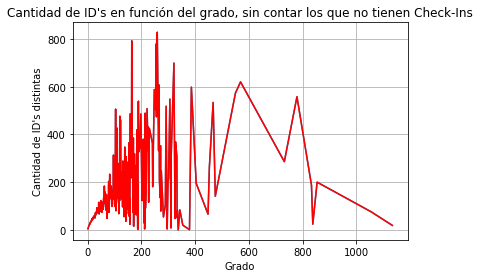

Esto tardó 73.21018767356873 segundos
Esto tardó 93.59635353088379 segundos


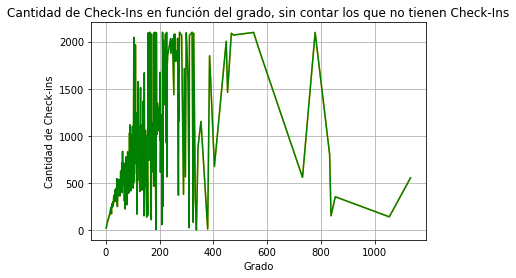

In [29]:
# Voy a juntar acá a los histogramas

# Distribuciòn de cantidad de localidades distintas visitadas

import math

Histo=[]

for x in DictID.values():
    Histo.append(len(x))

Bin=math.floor(max(Histo)/5)

plt.hist(Histo,bins=Bin,log=True)
plt.grid()
plt.show()

#-----------------------------------------------------------------
# Ahora hagamos distribuciòn de grado

Grado=[]

for x in G.degree():
    Grado.append(x[1])
  
A= np.mean(Grado)

Bin=math.floor(max(Grado)/10)

plt.hist(Grado,bins=Bin,log=True)
plt.grid()
plt.show()

#-----------------------------------------------------------------------

# Debería hacer una relación entre distribución de grado Cantidad de ID's visitados

t0=time.time()

# Me armo un diccionario de grado para cada nodo
DictGrado = dict()

Gradmax=0

for x in G.degree():
    DictGrado[x[0]]=x[1]
    Gradmax=max(Gradmax,x[1])

Lgrados= list(set(Grado))
Lgrados.sort()

X=[]
Y=[]

# Este método tarda mucho, busquemos otra forma de armar el gráfico
# for grad in Lgrados:
#     LPromed = []
#     for pareja in DictGrado.items():
#         if pareja[0] in NCC and pareja[1]==grad:
#             LPromed.append(len(DictID[pareja[0]]))
#         if pareja[0] not in NCC and pareja[1]==grad:
#             LPromed.append(0)
#     Promed=np.mean(LPromed)
#     X.append(grad)
#     Y.append(Promed)
    
    
#--------------------------------------------------------

# GradID = []

# for nodo in NCC:
#     GradID.append([nodo,DictGrad[nodo],len(DictID[nodo])])

# # Ya me armé la lista de grado e ID, la sorteo según grado
# GradID.sort(key=lambda x:x[1])

#--------------------------------------------------------------

DictGID = dict()
# DictGID es un diccionario que a cada grado le va a asignar una lista con 
# la cantidad de ID's distintos visitados por cada usuario.
# Pero no guarda registro de cuales nodos son los que tenían ese grado o ese ID

for grad in Lgrados:
    DictGID[grad]=[]

for tupla in G.degree():
    if int(tupla[0]) in NCC:
        DictGID[tupla[1]].append(len(DictID[tupla[0]]))
    if int(tupla[0]) in NotCC:
        DictGID[tupla[1]].append(0)

# Lo siguiente me arma mis listas X e Y con los valores a plotear, asignándolos de manera
# Correspondiente a los valores en X e Y. Espero que el hecho de que no estén ordenados no
# sea un problema
        
for pareja in DictGID.items():
    x=pareja[0]
    y=np.mean(pareja[1])
    X.append(x)
    Y.append(y)




Tiempo()

   
plt.plot(X,Y)
# plt.grid()
# plt.xlabel("Grado")
# plt.ylabel("Cantidad de ID's distintas")
# plt.title("Cantidad de ID's en función del grado")
# plt.show()

#---------------------------------------------------------

# Ahora hagámoslo sin contar los tipos con 0 Checkins

for grad in Lgrados:
    DictGID[grad]=[]

for tupla in G.degree():
    if int(tupla[0]) in NCC:
        DictGID[tupla[1]].append(len(DictID[tupla[0]]))


# Lo siguiente me arma mis listas X e Y con los valores a plotear, asignándolos de manera
# Correspondiente a los valores en X e Y. Espero que el hecho de que no estén ordenados no
# sea un problema

X=[]
Y=[]
        
for pareja in DictGID.items():
    if len(pareja[1])!=0:
        x=pareja[0]
        y=np.mean(pareja[1])
        X.append(x)
        Y.append(y)

Tiempo()        

plt.plot(X,Y,"r")
plt.grid()
plt.xlabel("Grado")
plt.ylabel("Cantidad de ID's distintas")
plt.title("Cantidad de ID's en función del grado, sin contar los que no tienen Check-Ins")
plt.show()

#--------------------------------------------------------------------

# Por último, hagámoslo para el largo total de los ID's

for grad in Lgrados:
    DictGID[grad]=[]

for tupla in G.degree():
    if int(tupla[0]) in NCC:
        DictGID[tupla[1]].append(len(DictIDT[tupla[0]]))
    if int(tupla[0]) in NotCC:
        DictGID[tupla[1]].append(0)


# Lo siguiente me arma mis listas X e Y con los valores a plotear, asignándolos de manera
# Correspondiente a los valores en X e Y. Espero que el hecho de que no estén ordenados no
# sea un problema

X=[]
Y=[]
        
for pareja in DictGID.items():
    x=pareja[0]
    y=np.mean(pareja[1])
    X.append(x)
    Y.append(y)

        
Tiempo()
        
plt.plot(X,Y,"orange")
# plt.grid()
# plt.xlabel("Grado")
# plt.ylabel("Cantidad de Check-ins")
# plt.title("Cantidad de Check-Ins en función del grado")
# plt.show()

#---------------------------------------------------------------

# Por último último, hagámoslo sin contar los vacíos de check-ins
# Para cantidad total de Check-ins

for grad in Lgrados:
    DictGID[grad]=[]

for tupla in G.degree():
    if int(tupla[0]) in NCC:
        DictGID[tupla[1]].append(len(DictIDT[tupla[0]]))


# Lo siguiente me arma mis listas X e Y con los valores a plotear, asignándolos de manera
# Correspondiente a los valores en X e Y. Espero que el hecho de que no estén ordenados no
# sea un problema

X=[]
Y=[]
        
for pareja in DictGID.items():
    if len(pareja[1])!=0:
        x=pareja[0]
        y=np.mean(pareja[1])
        X.append(x)
        Y.append(y)

        
Tiempo()        

plt.plot(X,Y,"g")
plt.grid()
plt.xlabel("Grado")
plt.ylabel("Cantidad de Check-ins")
plt.title("Cantidad de Check-Ins en función del grado, sin contar los que no tienen Check-Ins")
plt.show()

In [51]:
# Defino la similitud entre dos usuarios como el valor normalizado entre 0 y 1
# Que resulta de contar la cantidad de lugares comunes que visitan y al número ese 
# Dividirlo por el máximo de la cantidad de lugares que visitan cada uno

# Primero voy a analizar similitud entre amigos.

t0=time.time()

i=0

MatSimil = []

for nodo1 in DictID.keys():
    Vecinos = G[nodo1] # Esto es un dict con todos los amigos del nodo1
    FilaSimil =[]
    for nodo2 in Vecinos:
        if int(nodo2) in NCC:
            Conj1 = set(DictID[nodo1])
            Conj2 = set(DictID[nodo2])
            Conj3 = Conj1.intersection(Conj2)
            ValSimil = len(Conj3)
            FilaSimil.append(ValSimil)
#             print(nodo1)
#             print(FilaSimil)
    MatSimil.append(FilaSimil)
    



t1=time.time()
print("Tardaste {} segundos".format(t1-t0))


Tardaste 104.53627347946167 segundos


In [2]:
# Por ahora a esto no lo voy a volver a usar
t0 = time.time()
Cat=["Nodo","Fecha","Latitud","Altitud","Id de Locación"]


Vacio=[]
Inicio=input("¿Desde que usuario queres empezar?: ")
Fin=input("¿Hasta que nodo llegamos?: ")
ret=int(input("¿Desde que fila empiezo?(Acordate de usar el ultimo lac):  "))
#V = [0]
for j in range(int(Inicio),int(Fin)):
    Data=[]
    print("Estoy trabajando en el usuario {}".format(j))
    for x in Ubicacion[ret:]:
        if int(x[0])!=j:
            break
        Data.append(x)
    if len(Data)!=0:
        ret +=len(Data)
        pd.DataFrame(Data).to_csv('Checkins nodo/Checkin{},lac{}.csv'.format(j,ret),header=Cat)
        print("Ya armé la lista de check ins del usuario {}".format(j))
    if len(Data)==0:
        print("El usuario {} no tiene check ins".format(j))
        Vacio.append(j)
t1 = time.time()
print("Tardaste este tiempo {}".format(t1-t0))
